In [ ]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

In [ ]:
!pip uninstall lightgbm --yes

Found existing installation: lightgbm 4.5.0
Uninstalling lightgbm-4.5.0:
  Successfully uninstalled lightgbm-4.5.0


In [ ]:
!pip install lightgbm \
    --no-binary lightgbm \
    --no-cache lightgbm \
    --config-settings=cmake.define.USE_CUDA=ON

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 151.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lightgbm: filename=lightgbm-4.6.0-py3-none-linux_x86_64.whl size=61749734 sha256=fe89a34a9839aee977d3b4f4503855427e6b559982c84f91770309fd72ce72c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-jc8jmiat/wheels/ee/da/90/bd694ce19848ae41071e6c926d1650e4581556bf5869a57fe0
Successfully built lightgbm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=a5881c123c6495411a64cf68a2d05cda398f20bc58b1d432609134fd2e81e4c0
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
# !signate list
# ! signate files --competition-id=264
!signate download --competition-id=264

sample_submit.csv

test.csv

train.csv


Download completed.


In [ ]:
import pandas as pd
import numpy as np
import re

# ヘッダ有りとヘッダ無しCSVに区別して読み取る
train = pd.read_csv("/content/train.csv", header=0)
test = pd.read_csv("/content/test.csv")
submit = pd.read_csv("/content/sample_submit.csv", header=None, names=["id", "賃料"])

In [ ]:
train["賃料"] = train["賃料"].apply(np.log)

In [ ]:
# データ結合(番号を振り直す)
combined = pd.concat([train,test],axis=0,ignore_index=True)
max_row = combined.shape[0]

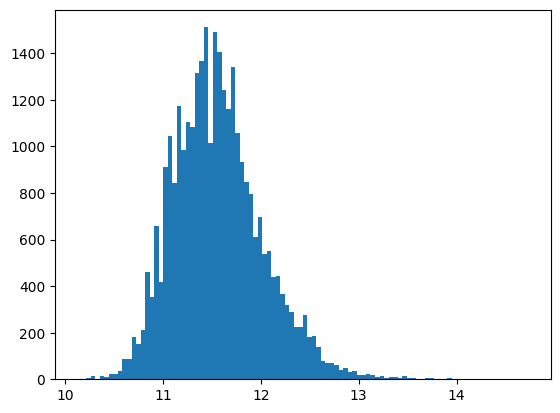

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 賃料を対数グラフにする

# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)

# ax.hist(train["賃料"].apply(np.log),bins=100)
# fig.show()


In [ ]:
# 編集する特徴量
# (OK)所在地 = 区しか利用価値ないためOK
# (OK)アクセス = 路線、最寄り駅、徒歩○分
# (そのままで)間取り = そのまま
# (OK)築年数 = ヶ月単位に変換
# (そのままで)方角 = そのまま、南向き、西向きのフラグが良いかも
# (OK)面積 = 数値に治す
# (済)所在階 = 階数に変換
#----------------------------------------休憩
# (OK)バス・トイレ = バス・トイレ別フラグ
# (OK)キッチン = コンロタイプで分類
# (OK)放送・通信 = ネット対応、ケーブルテレビ、CS
#----------------------------------------休憩
# (OK)室内設備 = エアコン、シューズボックス
# (OK)駐車場 = 有りorなし
# (OK)周辺環境 = 小学校、大学
# (そのままでOK)建物構造 = RC
# (OK)契約期間 = 定期借家、契約年数

# 特徴量を全部まとめていく

In [ ]:
# (2)「所在地」について
combined["地区"] = "0"
for row in range(max_row):
  combined.loc[row,"地区"] = re.split("[都区]", combined["所在地"][row])[1]

# 元のカラムを消去
combined = combined.drop(["所在地"], axis=1)

#---------------------------------------------------------------------------------
# (3) 「アクセス」 = 「路線」「最寄り駅」「徒歩時間」に分ける
combined["路線"] = "0"
combined["最寄り駅"] = "0"
# combined["徒歩時間"] = "0" 無関係だと思う
for row in range(max_row):
  combined.loc[row,"路線"] = re.split("[\t]", combined["アクセス"][row])[0]
  combined.loc[row,"最寄り駅"] = re.split("[\t]", combined["アクセス"][row])[1]
  # combined.loc[row,"徒歩時間"] = re.split("[\t]", combined["アクセス"][row])[2][-2:-1]

# 元のカラムを消去
combined = combined.drop(["アクセス"], axis=1)

#---------------------------------------------------------------------------------
# (4) 間取り = あまり関係ないように見えるので保留
# (「納戸」を抹消する)
# combined["間取り2"] = "0"

# for i in range(len(combined)):
#   if(combined.loc[i,"間取り"][-4:])=="(納戸)":
#     combined.loc[i,"間取り2"] = combined.loc[i,"間取り"][:-6]
#   else:
#     combined.loc[i,"間取り2"] = combined.loc[i,"間取り"]
#---------------------------------------------------------------------------------
# (5) 築年数(ヶ月に換算する)
combined["築ヶ月"] = "0"
for i, val in enumerate(combined["築年数"]):

  # 「新築」表記を無くす
  if(val == "新築"):
    combined.loc[i,"築ヶ月"] = "0"
    total = int(0)

  else:
    year = re.split("[年月ヶ]",combined["築年数"][i])[0]
    month = re.split("[年月ヶ]",combined["築年数"][i])[1]
    total = int(year) * 12 + int(month)
  combined.loc[i,"築ヶ月"] = total

# キャストする
combined["築ヶ月"] = combined["築ヶ月"].astype("int32")

# 元のカラムを消去
combined = combined.drop(["築年数"], axis=1)

#---------------------------------------------------------------------------------
# (7) 面積(数値に直す)
combined["面積値"] = "0"
for i in range(max_row):
  combined.loc[i, "面積値"] = combined["面積"][i][:-2]

# キャストする
combined["面積値"] = combined["面積値"].astype("float32")

# 元のカラムを消去
combined = combined.drop(["面積"], axis=1)

#---------------------------------------------------------------------------------
# (8) 所在階 = 階数に変換。欠損は2階を入れておく
combined["所在階"] = combined["所在階"].fillna("2")
combined["階"] = "0"
for i in range(max_row):
  combined.loc[i, "階"] = re.split("[階]", combined["所在階"][i])[0]

# 元のカラムを消去
combined = combined.drop(["所在階"], axis=1)
# (9)「バス・トイレ」について
combined["バス・トイレ"] = combined["バス・トイレ"].fillna("nodata")
combined["専用バス"] = "0"
combined["専用トイレ"] = "0"
combined["追焚機能"] = "0"
combined["浴室乾燥機"] = "0"
combined["温水洗浄便座"] = "0"
combined["洗面台独立"] = "0"
for row in range(max_row):
  tmp = re.split("[\t]", combined["バス・トイレ"][row])

  # 空要素を削除
  tmp = [i for i in tmp if i != ""]

  # フラグ
  for i, term in enumerate(tmp):
    if term == "専用バス":
      combined.loc[row,"専用バス"] = "1"
    if term == "専用トイレ":
      combined.loc[row,"専用トイレ"] = "1"
    if term == "追焚機能":
      combined.loc[row,"追焚機能"] = "1"
    if term == "浴室乾燥機":
      combined.loc[row,"浴室乾燥機"] = "1"
    if term == "温水洗浄便座":
      combined.loc[row,"温水洗浄便座"] = "1"
    if term == "洗面台独立":
      combined.loc[row,"洗面台独立"] = "1"

# 元のカラムを消去
combined = combined.drop(["バス・トイレ"], axis=1)

#---------------------------------------------------------------------
# (10)「キッチン」について
combined["キッチン"] = combined["キッチン"].fillna("nodata")

# 新規カラム
combined["ガスコンロ"] = "0"
combined["コンロ4口以上"] = "0"
combined["給湯"] = "0"
combined["システムキッチン"] = "0"
combined["カウンターキッチン"] = "0"
combined["電気コンロ"] = "0"

# フラグ処理
for row in range(max_row):
  tmp = re.split("[\t]", combined["キッチン"][row])

  # 空要素を削除
  tmp = [i for i in tmp if i != ""]

  # フラグ
  for i, term in enumerate(tmp):

    if term == "ガスコンロ":
      combined.loc[row,"ガスコンロ"] = "1"
    if term == "コンロ4口以上":
      combined.loc[row,"コンロ4口以上"] = "1"
    if term == "給湯":
      combined.loc[row,"給湯"] = "1"
    if term == "システムキッチン":
      combined.loc[row,"システムキッチン"] = "1"
    if term == "カウンターキッチン":
      combined.loc[row,"カウンターキッチン"] = "1"
    if term == "IHコンロ":
      combined.loc[row,"IHコンロ"] = "1"

# 元のカラムを消去
combined = combined.drop(["キッチン"], axis=1)

#---------------------------------------------------------------------
# (11)「放送・通信」について
combined["放送・通信"] = combined["放送・通信"].fillna("nodata")

# 新規カラム
combined["インターネット対応"] = "0"
combined["光ファイバー"] = "0"
combined["CATV"] = "0"
combined["CSアンテナ"] = "0"
combined["BSアンテナ"] = "0"

# フラグ処理
for row in range(max_row):
  tmp = re.split("[\t]", combined["放送・通信"][row])

  # 空要素を削除
  tmp = [i for i in tmp if i != ""]

  # フラグ
  for i, term in enumerate(tmp):
    if term == "インターネット対応":
      combined.loc[row,"インターネット対応"] = "1"
    if term == "光ファイバー":
      combined.loc[row,"光ファイバー"] = "1"
    if term == "CATV":
      combined.loc[row,"CATV"] = "1"
    if term == "CSアンテナ":
      combined.loc[row,"CSアンテナ"] = "1"
    if term == "BSアンテナ":
      combined.loc[row,"BSアンテナ"] = "1"

# 元のカラムを消去
combined = combined.drop(["放送・通信"], axis=1)
# (12)「室内設備」について
combined["室内設備"] = combined["室内設備"].fillna("nodata")

# 新規カラム
combined["エアコン付"] = "0"
combined["バルコニー"] = "0"
combined["フローリング"] = "0"
combined["室内洗濯機置場"] = "0"
combined["敷地内ゴミ置き場"] = "0"
combined["エレベーター"] = "0"
combined["都市ガス"] = "0"
combined["ロフト付き"] = "0"
combined["オール電化"] = "0"
combined["床暖房"] = "0"
combined["シューズボックス"] = "0"
combined["24時間換気システム"] = "0"
combined["タイル張り"] = "0"
combined["2面採光"] = "0"
combined["下水"] = "0"
combined["公営水道"] = "0"
combined["冷房"] = "0"

# フラグ処理
for row in range(max_row):
  tmp = re.split("[／\t]", combined["室内設備"][row])

  # 空要素を削除
  tmp = [i for i in tmp if i != ""]

  # フラグ
  for i, term in enumerate(tmp):
    if term == "エアコン付":
      combined.loc[row,"エアコン付"] = "1"
    if term == "バルコニー":
      combined.loc[row,"バルコニー"] = "1"
    if term == "フローリング":
      combined.loc[row,"フローリング"] = "1"
    if term == "室内洗濯機置場":
      combined.loc[row,"室内洗濯機置場"] = "1"
    if term == "敷地内ゴミ置き場":
      combined.loc[row,"敷地内ゴミ置き場"] = "1"
    if term == "エレベーター":
      combined.loc[row,"エレベーター"] = "1"
    if term == "都市ガス":
      combined.loc[row,"都市ガス"] = "1"
    if term == "ロフト付き":
      combined.loc[row,"ロフト付き"] = "1"
    if term == "オール電化":
      combined.loc[row,"オール電化"] = "1"
    if term == "床暖房":
      combined.loc[row,"床暖房"] = "1"
    if term == "シューズボックス":
      combined.loc[row,"シューズボックス"] = "1"
    if term == "24時間換気システム":
      combined.loc[row,"24時間換気システム"] = "1"
    if term == "タイル張り":
      combined.loc[row,"タイル張り"] = "1"
    if term == "2面採光":
      combined.loc[row,"2面採光"] = "1"
    if term == "下水":
      combined.loc[row,"下水"] = "1"
    if term == "公営水道":
      combined.loc[row,"公営水道"] = "1"
    if term == "冷房":
      combined.loc[row,"冷房"] = "1"

# 元のカラムを消去
combined = combined.drop(["室内設備"], axis=1)
# (13)「駐車場」について
combined["駐車場"] = combined["駐車場"].fillna("nodata")

# 新規カラム
combined["空有"] = "0"
combined["バイク置き場"] = "0"

# フラグ処理
for row in range(max_row):
  tmp = re.split("[\t]", combined["駐車場"][row])

  # 空要素を削除
  tmp = [i for i in tmp if i != ""]

  # フラグ
  for i, term in enumerate(tmp):

    if term == "空有":
      combined.loc[row,"空有"] = "1"

    if term == "バイク置き場":
      combined.loc[row,"バイク置き場"] = "1"

# 元のカラムを消去
combined = combined.drop(["駐車場"], axis=1)
# (14)「周辺環境」について
combined["周辺環境"] = combined["周辺環境"].fillna("nodata")

# 新規カラム
combined["小学校"] = 2000
combined["大学"] = 2000
combined["公園"] = 2000
combined["飲食店"] = 2000
combined["スーパー"] = 2000
combined["ドラッグストア"] = 2000
combined["郵便局"] = 2000

# フラグ処理
for row in range(max_row):
  tmp = re.split("[ \t]", combined["周辺環境"][row])

  # 空要素を削除
  tmp = [i for i in tmp if i != ""]

  # フラグ
  for i, term in enumerate(tmp):
    if term == "【小学校】":
      combined.loc[row,"小学校"] = int(tmp[i+1] [:-1])
      break

  for i, term in enumerate(tmp):
    if term == "【大学】":
      combined.loc[row,"大学"] = int(tmp[i+1] [:-1])
      break

  for i, term in enumerate(tmp):
    if term == "【公園】":
      combined.loc[row,"公園"] = int(tmp[i+1] [:-1])
      break

  for i, term in enumerate(tmp):
    if term == "【飲食店】":
      combined.loc[row,"飲食店"] = int(tmp[i+1] [:-1])
      break

  for i, term in enumerate(tmp):
    if term == "【スーパー】":
      combined.loc[row,"スーパー"] = int(tmp[i+1] [:-1])
      break

  for i, term in enumerate(tmp):
    if term == "【ドラッグストア】":
      combined.loc[row,"ドラッグストア"] = int(tmp[i+1] [:-1])
      break

  for i, term in enumerate(tmp):
    if term == "【郵便局】":
      combined.loc[row,"郵便局"] = int(tmp[i+1] [:-1])
      break

# 元のカラムを消去
combined = combined.drop(["周辺環境"], axis=1)
# 「契約期間」について
combined["契約期間"] = combined["契約期間"].fillna("nodata")
combined["定期借家"] = "0"
combined["契約年数"] = "0"
for row in range(max_row):
  tmp = re.split("[\t]", combined["契約期間"][row])

  # 空要素を削除
  tmp = [i for i in tmp if i != ""]

  # 定期借家フラグ
  for i, term in enumerate(tmp):
    if term == "定期借家":
      combined.loc[row,"定期借家"] = "1"

  # 契約年数
  combined.loc[row,"契約年数"] = tmp[0]

KeyboardInterrupt: 

In [ ]:
# 取り除く変数
RMV = ["id", "賃料"]
FEATURES = [c for c in combined.columns if not c in RMV]

# カテゴリ変数の分類
CATS = []
for c in FEATURES:
  if combined[c].dtype == "object":
    CATS.append(c)
    combined[c] = combined[c].fillna("nodata")
    # test[c] = test[c].fillna("NAN")

In [ ]:
# 特徴量の整理
for c in FEATURES:

  # カテゴリ変数の場合はラベルエンコード
  for c in CATS:
    combined[c],_ = combined[c].factorize()

    combined[c] -= combined[c].min() # 最小値で引く
    combined[c] = combined[c].astype("int32")

  # 数値の場合はメモリを減らす
  else:
    if combined[c].dtype == "float64":
      combined[c] = combined[c].astype("float32")
    if combined[c].dtype == "int64":
      combined[c] = combined[c].astype("int32")

# 結合を戻す
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

In [ ]:
!pip install optuna lightgbm scikit-learn

In [ ]:
  lgbm_params = {
      'objective': 'regression',
      "device": "cuda",
      'metric': 'rmse',
      'verbosity': 100,
      'num_boost_round': 6000,
      'boosting_type': 'gbdt',
      'learning_rate': 0.05,            # 学習率
      'num_leaves': 31,                 # 葉の数
      'max_depth': -1,                  # 木の深さ（デフォルトは無制限）
      'feature_fraction': 0.9,          # 学習に使用する特徴量の割合
      'bagging_fraction': 0.8,          # サンプリングの割合
      'bagging_freq': 5,                # バギングの頻度（1回ごと、あるいは5回ごと）
      'verbose': -1                     # ログ出力の制御
      }

In [ ]:
%%time
FOLDS = 5 # 分割数
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, "賃料"]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, "賃料"]
  x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        valid_sets = lgb_eval,
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=True),
                            # lgb.log_evaluation(100),
                            ])


  y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid)
  pred_lgb += model_lgb.predict(x_test)

# 平均評価
pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[LightGBM] [Warning] verbosity is set=100, verbose=-1 will be ignored. Current value: verbosity=100
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] verbosity is set=100, verbose=-1 will be ignored. Current value: verbosity=100
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.625800
[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 52
[LightGBM] [Warning] verbosity is set=100, verbose=-1 will be ignored. Current value: verbosity=100
[LightGBM] [Debug] Adding init score = 118394.632904
[LightGBM] [Debug] Adding init score = 118394.632904
[LightGBM] [Info] Start training from score 118394.632904
[LightGBM] [Debug] Re-bagging, using 20173 data to train
Training until validation scores don't improve for 100 rounds
[LightGBM] [Debug] Re-bagging, using 20176 data to train
[LightGBM] [

In [ ]:
from sklearn.metrics import mean_squared_error

# 検証用スコアデータの算出
y_true = train["賃料"].tolist()
m = np.sqrt(mean_squared_error(y_true, oof_lgb.tolist()))
print(f"\nOverall CV for LightGBM = ",m)


Overall CV for LightGBM =  22622.46377226914


In [ ]:
submit["賃料"] = pd.DataFrame(pred_lgb)

In [ ]:
submit.to_csv("submission.csv", header=False, index=False)

In [ ]:
# %%time
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from xgboost import XGBRegressor, XGBClassifier
import xgboost
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error

# lambda_l1 (L1正則化項の係数)
# lambda_l2 (L2正則化項の係数)
# num_leaves (1本の木の最大葉枚数)
# feature_fraction (各決定木においてランダムに抽出される列の割合)
# bagging_fraction (各決定木においてランダムに抽出される標本の割合)
# bagging_freq (ここで指定したイテレーション毎にバギング実施)
# min_child_sample (1枚の葉に含まれる最小データ数)

# チューニング開始
def objective(trial):

  # ハイパーパラメータの探索空間を定義
  param = {
      'objective': 'regression',
      "device": "cuda",
      'metric': 'rmse',
      'verbosity': -1,
      'boosting_type': 'gbdt',
      'learning_rate': 0.04492708210966157,
      # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1), # 10回
      'feature_fraction': 0.9103130112582689,
      # 'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0), # 7回
      'num_leaves': 224, # 20回
      # 'num_leaves': trial.suggest_int('num_leaves', 2, 256), # 20回
      'bagging_fraction': 0.9568588888194215,
      'bagging_freq': 1,
      # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0), # 10 回
      # 'bagging_freq': trial.suggest_float('bagging_freq', 1, 7), # 10回
      'feature_fraction': 0.9591216929519641,
      # 'feature_fraction': trial.suggest_float('feature_fraction', 1, 7), # 7回
      'lambda_l1': 0.0709541557442255,
      'lambda_l2': 8.094433861762296e-07,
      # 'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0), 20回
      # 'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
      'min_data_in_leaf': 18,
      # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100), # 10回
      }

  FOLDS = 5 # 分割数
  kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

  oof_lgb = np.zeros(len(train))
  # pred_lgb = np.zeros(len(test))

  for i, (train_index, test_index) in enumerate(kf.split(train)):

    # print("#"*25)
    print(f"### Fold {i+1}")
    # print("#"*25)

    # インデックスに割り振る
    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, "賃料"]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, "賃料"]
    x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(param,
                          lgb_train,
                          valid_sets = lgb_eval,
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              ])

    y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    oof_lgb[test_index] = model_lgb.predict(x_valid)
    # pred_lgb += model_lgb.predict(x_test)

  # 平均評価
  # oof_lgb /= FOLDS
  # pred_lgb /= FOLDS

  # 検証用スコアデータの算出
  y_true = train["賃料"].tolist()
  m = np.sqrt(mean_squared_error(y_true, oof_lgb.tolist()))
  # print(f"\nOverall CV for LightGBM = ",m)
  return m

# Optunaで最適化を実行
study = optuna.create_study(direction='minimize')  # RMSEを最小化する方向で最適化

study.optimize(objective, n_trials=5)
print(f'trial: {study.best_trial.params}')
print(f'Best trial: {study.best_trial.params}')

[I 2025-03-15 23:23:57,517] A new study created in memory with name: no-name-f9522470-0bec-48ee-a453-3fea0617c70c


### Fold 1
### Fold 2
### Fold 3
### Fold 4
### Fold 5


[I 2025-03-15 23:24:20,769] Trial 0 finished with value: 26689.29609199935 and parameters: {'min_data_in_leaf': 28}. Best is trial 0 with value: 26689.29609199935.


### Fold 1
### Fold 2
### Fold 3
### Fold 4
### Fold 5


[I 2025-03-15 23:24:41,609] Trial 1 finished with value: 25057.236880700406 and parameters: {'min_data_in_leaf': 18}. Best is trial 1 with value: 25057.236880700406.


### Fold 1
### Fold 2
### Fold 3
### Fold 4
### Fold 5


[I 2025-03-15 23:25:02,977] Trial 2 finished with value: 28582.716812684048 and parameters: {'min_data_in_leaf': 61}. Best is trial 1 with value: 25057.236880700406.


### Fold 1
### Fold 2
### Fold 3
### Fold 4
### Fold 5


[I 2025-03-15 23:25:23,196] Trial 3 finished with value: 30744.405816473438 and parameters: {'min_data_in_leaf': 88}. Best is trial 1 with value: 25057.236880700406.


### Fold 1
### Fold 2
### Fold 3
### Fold 4
### Fold 5


[I 2025-03-15 23:25:42,034] Trial 4 finished with value: 30834.02979418597 and parameters: {'min_data_in_leaf': 91}. Best is trial 1 with value: 25057.236880700406.


trial: {'min_data_in_leaf': 18}
Best trial: {'min_data_in_leaf': 18}


In [ ]:
# ベースラインを作成する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from xgboost import XGBRegressor, XGBClassifier
import xgboost
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier


# LGBMパラメータ
# lgbm_params = {
#     "objective": "regression",
#     # "device": "gpu",
#     "device": "cuda",
#     'verbose': -1,
#     "boosting": "gbdt",
#     'metric': 'rmse',
#     'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#     # 'min_child_samples': 32,
#     # 'max_depth': 8,
#     # 'max_bin': 128,
#     # "colsample_bytree": 0.4,
#     # "subsample": 0.9,
#     # 'learning_rate': 0.1,
#     # 'extra_trees': True,
#     # 'reg_lambda': 8.0,
#     # 'reg_alpha': 0.1,
#     # 'num_leaves': 64,
#     "seed": 1234,
#     # "is_enable_sparse": "False",
# }


# OptunaでLightGBMのハイパーパラメータを最適化する関数
def objective(trial):
    # ハイパーパラメータの探索空間を定義
    param = {
        'objective': 'regression',
        "device": "cuda",
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
        # 'num_leaves': trial.suggest_int('num_leaves', 2, 256), # 20回
        # 'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        # 'bagging_freq': trial.suggest_uniform('bagging_freq', 1, 7),
        # 'feature_fraction': trial.suggest_uniform('feature_fraction', 1, 7), # 2回目
        # 'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        # 'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
        # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

    # 学習
    model_lgb = lgb.train(param,
                          lgb_train,
                          valid_sets = lgb_eval,
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=True),
                              lgb.log_evaluation(100),])


    y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    oof_lgb[test_index] = model_lgb.predict(x_valid)

    # 検証データで予測
    y_pred = model.predict(X_valid)

    # RMSE (Root Mean Squared Error) を手動で計算
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)  # MSEの平方根を取ってRMSEを計算

    return rmse

# Optunaで最適化を実行
study = optuna.create_study(direction='minimize')  # RMSEを最小化する方向で最適化
study.optimize(objective, n_trials=100)

In [ ]:
%%time
FOLDS = 5 # 分割数
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, "賃料"]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, "賃料"]
  x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        valid_sets = lgb_eval,
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=True),
                            lgb.log_evaluation(100),])


  y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid)
  pred_lgb += model_lgb.predict(x_test)

# 平均評価
pred_lgb /= FOLDS